# XAI MODEL BUILD

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Train and Test Datasets

In [3]:
!pip install lime
!pip install shap
import pandas as pd
import numpy as np
import joblib
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/test.csv')

X_train = df_train.drop(['Label'], axis=1)  # Features
y_train = df_train['Label']  # Target variable

X_test = df_test.drop(['Label'], axis=1)  # Features
y_test = df_test['Label']  # Target variable


# load the trained model to a specific folder
model_folder = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_XGBoost.joblib"
model_path = model_folder + model_filename

model = joblib.load(model_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1f9b57699cd6d2e11ddfded10c56a26ff7a636fd337821aa697e4e38b661911d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# Explainability Models

# SHAP Interpretability

In [4]:
import shap
import psutil
import tracemalloc
import time
import joblib
import pandas as pd
import matplotlib.pyplot as plt

shap.initjs()


X_test = pd.DataFrame(X_test, columns=X_train.columns)
X_test = X_test.astype(X_train.dtypes)


cpu_usage_before = psutil.cpu_percent(interval=1)
disk_io_before = psutil.disk_io_counters().write_bytes
start_time_shap = time.time()
tracemalloc.start()


sample_size = min(100, len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)


explainer = shap.TreeExplainer(model)


shap_values = explainer(X_test_sample)


end_time_shap = time.time()
current_memory_shap, peak_memory_shap = tracemalloc.get_traced_memory()
tracemalloc.stop()
cpu_usage_after = psutil.cpu_percent(interval=1)
disk_io_after = psutil.disk_io_counters().write_bytes


execution_time_shap = end_time_shap - start_time_shap
memory_used_shap = (peak_memory_shap - current_memory_shap) / (1024 * 1024)  # Convert to MB
cpu_usage_change_shap = cpu_usage_after - cpu_usage_before  # Compute CPU usage difference
disk_io_used_shap = (disk_io_after - disk_io_before) / (1024 * 1024)  # Convert to MB


print("\n🔹 **SHAP Computational Overhead Report** 🔹")
print(f"⏳ **Execution Time:** {execution_time_shap:.4f} seconds")
print(f"💾 **Peak Memory Usage:** {memory_used_shap:.2f} MB")
print(f"🖥️ **CPU Usage Change:** {cpu_usage_change_shap:.2f}%")
print(f"📂 **Disk I/O Usage:** {disk_io_used_shap:.2f} MB")



🔹 **SHAP Computational Overhead Report** 🔹
⏳ **Execution Time:** 58.6821 seconds
💾 **Peak Memory Usage:** 7.21 MB
🖥️ **CPU Usage Change:** -2.10%
📂 **Disk I/O Usage:** 29.80 MB


In [5]:
encoder_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/label_encoder.pkl"
label_encoder = joblib.load(encoder_path)

actual_class_names = label_encoder.classes_
print(actual_class_names)

['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack']


# EVALUATION METRICS

# SHAP Explanation

In [6]:
import numpy as np
from scipy.stats import spearmanr

# Functions for Metrics
def calculate_local_explanation_quality(predicted_explanations, actual_model_outputs):
    """
    Calculate the Local Explanation Quality (Fidelity Local).

    Args:
        predicted_explanations (np.ndarray): Predicted explanation outputs (e.g., SHAP predicted values).
        actual_model_outputs (np.ndarray): Actual local model outputs.

    Returns:
        float: Local explanation quality score.
    """
    N = len(predicted_explanations)
    fidelity_local = 1 - np.sqrt(np.mean(predicted_explanations - actual_model_outputs) ** 2) / N
    return fidelity_local

def calculate_global_explanation_quality(feature_importance_values, domain_importance_values):
    """
    Calculate the Global Explanation Utility using Spearman's Rank Correlation.

    Args:
        feature_importance_values (np.ndarray): Feature importance values (e.g., SHAP feature importance).
        domain_importance_values (np.ndarray): Domain knowledge importance values.

    Returns:
        float: Spearman's Rank Correlation.
    """
    if len(feature_importance_values) != len(domain_importance_values):
        raise ValueError("The number of domain importance scores must match the number of SHAP features.")
    correlation, _ = spearmanr(feature_importance_values, domain_importance_values)
    return correlation

# SHAP Local Explanation (using Waterfall Plot)

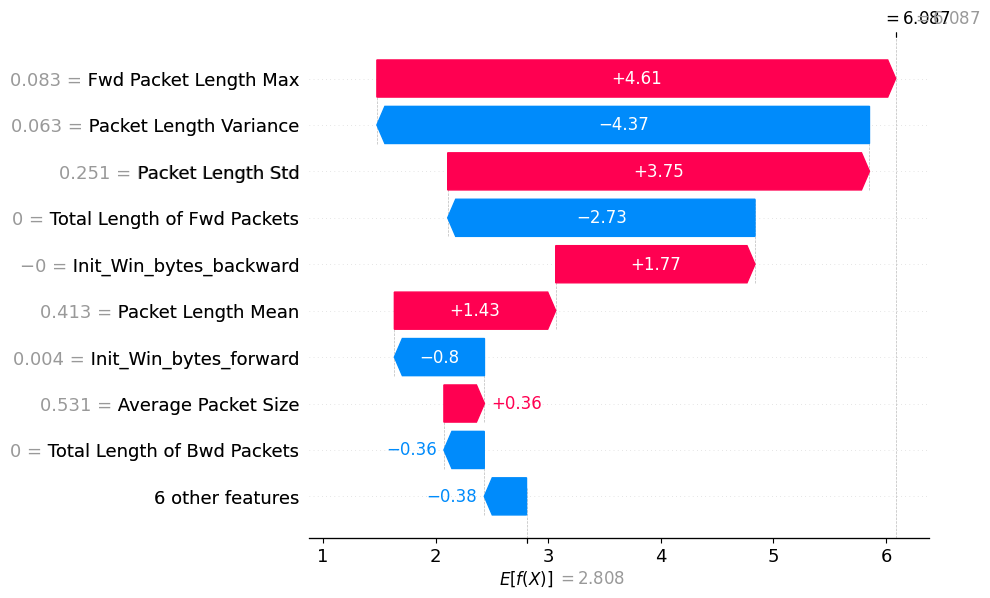

In [21]:
class_idx = 0
instance_index = np.argmax(np.abs(model.predict_proba(X_test_sample)[:, 1] - 0.5))

shap_explanation = shap.Explanation(
    values=shap_values.values[instance_index, :, class_idx],
    base_values=shap_values.base_values[instance_index, class_idx],
    data=X_test_sample.iloc[instance_index],
    feature_names=X_test_sample.columns
)

#Plot the waterfall chart
shap.plots.waterfall(shap_explanation)

# 1. SHAP Local Explanation Quality (LEQ) (Fidelity)

In [22]:
# Extract SHAP values for the class
shap_class_values = shap_values.values[:, :, class_idx]  # Shape: (samples, features)

# Get base values for the class
base_class_values = shap_values.base_values[:, class_idx]  # Shape: (samples,)

# Reconstruct predicted probabilities using SHAP additivity
shap_reconstructed = shap_class_values.sum(axis=1) + base_class_values  # Shape: (samples,)

# Get actual model probabilities
actual_model_outputs = model.predict_proba(X_test_sample)[:, class_idx]  # Shape: (samples,)

# Compute fidelity
local_quality = calculate_local_explanation_quality(shap_reconstructed, actual_model_outputs)

print(f"✅ SHAP Local Explanation Quality (Fidelity Local) for Class {class_idx}: {local_quality:.4f}")


✅ SHAP Local Explanation Quality (Fidelity Local) for Class 0: 0.9715


# SHAP Aproximation plot

Class 0 Fidelity: 0.9148
Class 1 Fidelity: 0.8576
Class 2 Fidelity: 0.9017
Class 3 Fidelity: 0.8889
Class 4 Fidelity: 0.9010
Class 5 Fidelity: 0.8666
Class 6 Fidelity: 0.8766
Class 7 Fidelity: 0.9018
Class 8 Fidelity: 0.9099
Class 9 Fidelity: 0.9035
Class 10 Fidelity: 0.8840
Class 11 Fidelity: 0.8968
Class 12 Fidelity: 0.8572


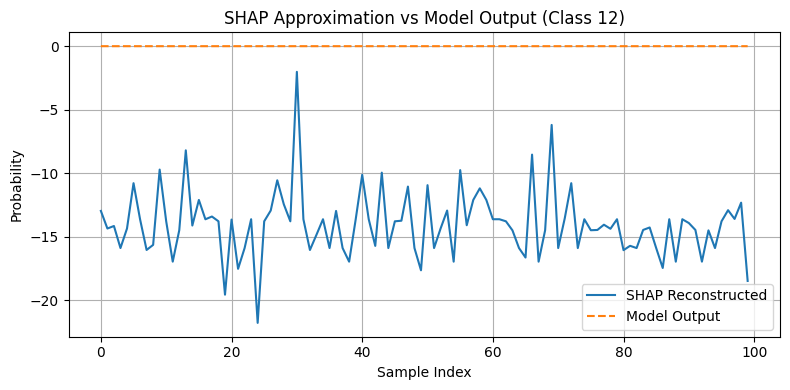

In [28]:
import matplotlib.pyplot as plt

for class_idx in range(shap_values.values.shape[2]):
    shap_class_values = shap_values.values[:, :, class_idx]
    base_class_values = shap_values.base_values[:, class_idx]
    shap_reconstructed = shap_class_values.sum(axis=1) + base_class_values
    N = len(shap_reconstructed)
    actual_outputs = model.predict_proba(X_test_sample)[:, class_idx]
    fidelity = 1 - np.sqrt(np.mean((shap_reconstructed - actual_outputs) ** 2)) / N
    print(f"Class {class_idx} Fidelity: {fidelity:.4f}")


plt.figure(figsize=(8, 4))
plt.plot(shap_reconstructed, label="SHAP Reconstructed")
plt.plot(actual_outputs, label="Model Output", linestyle='--')
plt.legend()
plt.title(f"SHAP Approximation vs Model Output (Class {class_idx})")
plt.xlabel("Sample Index")
plt.ylabel("Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


# SHAP Class-Specific Global Explanation

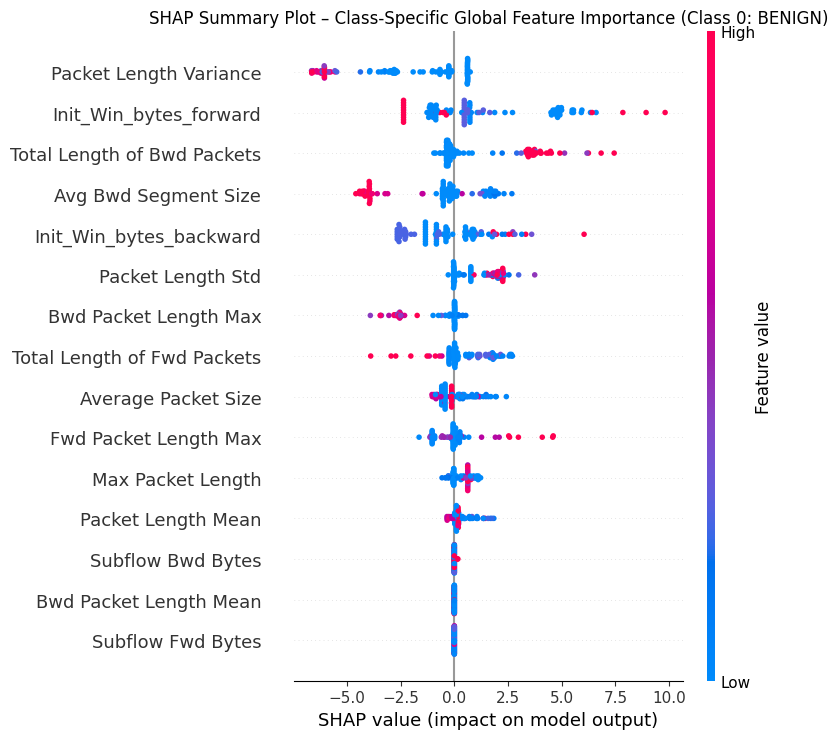

In [29]:
import shap
import matplotlib.pyplot as plt

class_idx = 0

shap_values_class = shap_values.values[:, :, class_idx]
X_test_df = pd.DataFrame(X_test_sample, columns=X_train.columns)

class_name = actual_class_names[class_idx]


title = f"SHAP Summary Plot – Class-Specific Global Feature Importance (Class {class_idx}: {class_name})"

shap.summary_plot(
    shap_values_class,
    X_test_df,
    plot_type="dot",
    feature_names=X_test_df.columns,
    show=False
)

plt.title(title)
plt.tight_layout()
plt.show()

# SHAP Global Feature Importance (Model-Derived)

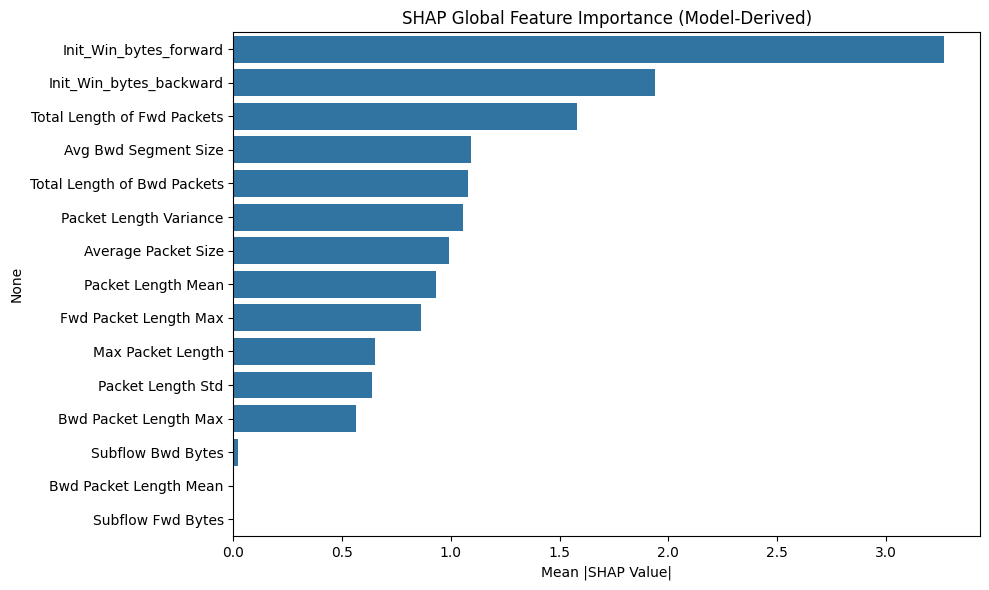

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

shap_feature_importance = np.abs(shap_values.values).mean(axis=(0, 2))

sorted_idx = np.argsort(shap_feature_importance)[::-1]
sorted_features = X_test.columns[sorted_idx]
sorted_importance = shap_feature_importance[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_features)
plt.title("SHAP Global Feature Importance (Model-Derived)")
plt.xlabel("Mean |SHAP Value|")
plt.tight_layout()
plt.show()

# SHAP Global Explanation Utility

In [31]:
# ✅ Aggregate SHAP feature importance across samples and classes (keep features)
shap_feature_importance = np.abs(shap_values.values).mean(axis=(0, 2))  # Shape (18,)

# ✅ Ensure SHAP importance matches number of features
if len(shap_feature_importance) != X_test.shape[1]:
    raise ValueError(f" SHAP feature count ({len(shap_feature_importance)}) does not match dataset feature count ({X_test.shape[1]}).")

# # ✅ Print SHAP Feature Importance Scores
# print("✅ SHAP Feature Importances (Mean Absolute Values):")
# for feature, importance in zip(X_test.columns, shap_feature_importance):
#     print(f"{feature}: {importance:.6f}")

# ✅ Define expert knowledge importance scores for 18 features
expert_importance_scores = np.array([
    0.0, 0.0, 0.1, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.1,
    0.05, 0.05, 0.03, 0.02, 0.01  # 18 values
])

# ✅ Ensure expert scores match SHAP feature count
if len(expert_importance_scores) != len(shap_feature_importance):
    raise ValueError(" Mismatch: Expert domain scores must match SHAP feature count.")

# ✅ Compute Spearman’s Rank Correlation
global_explanation_quality = calculate_global_explanation_quality(
    shap_feature_importance, expert_importance_scores
)

# ✅ Print result
print(f"✅ SHAP Global Explanation Quality (Spearman’s Rank Correlation): {global_explanation_quality:.4f}")

✅ SHAP Global Explanation Quality (Spearman’s Rank Correlation): 0.0467


# LLM Explainability Of SHAP

In [20]:
# !pip install openai
# !pip install python-dotenv
import os
import openai
from google.colab import userdata

# Initialize OpenAI client with API key
client = openai.OpenAI(api_key=userdata.get("OPENAI_API_KEY"))

# Select the instance to explain (e.g., index 0)
instance_index = 0

# Extract SHAP values for this instance and class
shap_vals = shap_values.values[instance_index, :, class_idx]
base_val = shap_values.base_values[instance_index, class_idx]
feature_vals = X_test.iloc[instance_index].to_dict()

# Build structured SHAP input summary
top_features = sorted(
    zip(X_test.columns, feature_vals.values(), shap_vals),
    key=lambda x: abs(x[2]),
    reverse=True
)[:5]  # top 5 features

# Format the top features as a readable string
top_feature_lines = "\n".join([
    f"- {name}: value={val}, shap={shap:.4f}" for name, val, shap in top_features
])

# LLM prompt
shap_description_prompt = f"""
You are a cybersecurity analyst assistant. Explain this prediction made by an AI intrusion detection system using SHAP values.

Base Model Output: {base_val:.4f}

Top Contributing Features:
{top_feature_lines}

Explain in clear, non-technical English:
- What the model is predicting
- Which features most influenced the decision
- What actions a human analyst might take next
"""

# Send request to OpenAI
response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a helpful AI assistant specialized in explainable machine learning for cybersecurity."},
        {"role": "user", "content": shap_description_prompt}
    ],
    max_tokens=500,
    temperature=0.6
)

# Output the explanation
print("SHAP Explanation in Plain English:")
print(response.choices[0].message.content)


SHAP Explanation in Plain English:
The model's prediction, represented by the Base Model Output of 2.8082, indicates a certain level of risk associated with a network intrusion. This risk level may be interpreted differently depending on the specific context and the scale used by the model, but in general, a higher value indicates a higher perceived risk.

The features that most influenced this decision, as indicated by the SHAP values, are Packet Length Variance, Total Length of Bwd Packets, Bwd Packet Length Max, Init_Win_bytes_backward, and Packet Length Std. 

Let's break down how each feature contributed:

1. Packet Length Variance: This feature had a negative influence on the model's output, meaning that the low variance in packet length (0.0979) decreased the perceived risk of a network intrusion. 

2. Total Length of Bwd Packets: Although the actual value of this feature was extremely small (1.769e-05), it positively influenced the model's output, increasing the perceived risk.

# LIME EXPLAINABILITY

In [34]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

def explain_with_lime(model, X_test, feature_names, instance_index=0, class_names=None):
    """
    Use LIME to generate an explanation for a model's prediction.

    Parameters:
    - model: Trained model to explain.
    - X_test: Test dataset (features only).
    - feature_names: List of feature names.
    - instance_index: Index of the instance to explain.
    - class_names: List of actual class names (from LabelEncoder).
    """
    # ✅ Initialize LIME explainer
    explainer = LimeTabularExplainer(
        X_test.values,  # Use raw values
        mode="classification",
        feature_names=feature_names,
        class_names=class_names,
        discretize_continuous=True
    )

    # ✅ Select instance to explain
    instance = X_test.iloc[[instance_index]].values  # Keep as 2D array

    # ✅ Measure computational time
    cpu_start = time.process_time()
    wall_start = time.time()

    # ✅ Generate explanation
    explanation = explainer.explain_instance(
        instance[0],  # Flatten instance
        lambda x: model.predict_proba(pd.DataFrame(x, columns=feature_names)),  # Fix model input
        num_features=len(feature_names),
        top_labels=3
    )

    # ✅ Measure computational time (end)
    cpu_end = time.process_time()
    wall_end = time.time()

    # ✅ Compute execution time
    cpu_time = cpu_end - cpu_start
    wall_time = wall_end - wall_start

    # ✅ Print computational cost report
    print(f"\n✅ **LIME Computational Cost Report**")
    print(f"✅ CPU Time: {cpu_time:.4f} seconds")
    print(f"✅ Wall Time: {wall_time:.4f} seconds")

    # ✅ Display explanation in notebook
    explanation.show_in_notebook(show_table=True, show_all=True)

    return explanation

# Lime Local Explanation - Instance-Level Feature Impact on Model Prediction

In [35]:
instance_id = 0
# target_class = 3

# Generate and store explanation
lime_exp = explain_with_lime(
    model=model,
    X_test=X_test_sample,
    feature_names=X_test_sample.columns.tolist(),
    instance_index=instance_id,
    class_names=actual_class_names,

)

# print("Available labels:", lime_exp.available_labels())
# if target_class in lime_exp.available_labels():
#     lime_exp.show_in_notebook(show_table=True, show_all=False, labels=[target_class])
# else:
#     print(f"⚠️ Class {target_class} not explained for this instance.")




✅ **LIME Computational Cost Report**
✅ CPU Time: 3.1523 seconds
✅ Wall Time: 5.1739 seconds


# Unified LIME Explanation Quality Evaluation (Local & Global) (for all instances)

In [36]:
import numpy as np
from scipy.stats import spearmanr

# Initialize global importance vector
lime_global_importance = np.zeros(len(X_train.columns))

# Store local explanations for fidelity
actual_model_outputs = model.predict_proba(X_test_sample)[:, class_idx]
lime_predicted_outputs = np.zeros_like(actual_model_outputs)

# Loop once over all test instances
for i in range(len(X_test_sample)):
    lime_exp = explain_with_lime(
        model=model,
        X_test=X_test_sample,
        feature_names=X_test_sample.columns.tolist(),
        instance_index=i,
        class_names=actual_class_names
    )

    label = list(lime_exp.local_exp.keys())[0]  # Class being explained

    # For local fidelity quality (get surrogate prediction)
    lime_predicted_outputs[i] = lime_exp.predict_proba[label]

    # For global importance aggregation
    for feature_idx, weight in lime_exp.local_exp[label]:
        lime_global_importance[feature_idx] += abs(weight)

Output hidden; open in https://colab.research.google.com to view.

# LIME Local Explanation Quality (Fidelity)

In [37]:
local_quality_lime = 1 - np.abs(actual_model_outputs - lime_predicted_outputs).mean()
print(f"LIME Local Explanation Quality (Fidelity Local): {local_quality_lime:.4f}")

LIME Local Explanation Quality (Fidelity Local): 0.3141


# LIME Global Explanation Utility (Spearmen)

In [38]:
# ✅ Normalize Global Importance
lime_global_importance /= len(X_test_sample)
lime_global_importance /= lime_global_importance.sum()


domain_importance_scores = np.array([
    0.09,  # Total Length of Bwd Packets
    0.07,  # Bwd Packet Length Max
    0.06,  # Subflow Bwd Bytes
    0.05,  # Init_Win_bytes_forward
    0.05,  # Packet Length Std
    0.04,  # act_data_pkt_fwd
    0.04,  # Packet Length Mean
    0.03,  # Total Length of Fwd Packets
    0.03,  # Packet Length Variance
    0.02,  # Init_Win_bytes_backward
    0.02,  # Avg Bwd Segment Size
    0.02,  # Subflow Fwd Bytes
    0.01,  # Bwd Packet Length Std
    0.01,  # Fwd IAT Std
    0.005, # Max Packet Length
])


domain_importance_scores /= domain_importance_scores.sum()


# ✅ Global Explanation Utility (Spearman)
global_utility_lime = spearmanr(lime_global_importance, domain_importance_scores)[0]
print(f"✅ LIME Global Explanation Utility (Spearman's Rank Correlation): {global_utility_lime:.4f}")

✅ LIME Global Explanation Utility (Spearman's Rank Correlation): 0.4802
